# Open Market Backtesting

### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn
seaborn.set()
import wrds
import sys
sys.path.append('..')

# Import Main Python Modules
from src.dataframe_construction import *
from src.a_estimation import *
from src.optimal_strategies import *
from src.backtest import *


### Backtesting

#### Setting up the data

In [2]:
daily = False
datapath='../data/'
backtest_start_year = 1970

if daily:
    d = 3000
    start_date_a_estimation='2013-01-01'
    end_date_a_estimation=str(backtest_start_year)+'-01-01'
    start_date_backtest=end_date_a_estimation
    end_date_backtest='2025-01-01'
    start_date='2013-01-01'
    filename='CRSP_2013_2018_daily_cleaned.h5'
    caps_table='dlyprevcap'
    returns_table='dlyret'
else:
    d = 2000
    start_date_a_estimation='1965-01-01'
    end_date_a_estimation=str(backtest_start_year)+'-01-01'
    start_date_backtest=end_date_a_estimation
    end_date_backtest='2025-01-01'
    filename='CRSP_monthly_cleaned.h5'
    caps_table='mthprevcap'
    returns_table='mthret'

df_a_estimation = Data(d=d, start_date=start_date_a_estimation, end_date=end_date_a_estimation, datapath=datapath, 
                       filename=filename, caps_table=caps_table, returns_table=returns_table)
df_backtest = Data(d=d, start_date=start_date_backtest, end_date=end_date_backtest, datapath=datapath, filename=filename, 
                   caps_table=caps_table, returns_table=returns_table)

#### Estimating $a$ and Computing Optimal Strategy

/home/pedro/Downloads/mathematical_finance/2-notebooks/../src/a_estimation.py:32: RuntimeWarning: overflow encountered in exp
  return a * (1 - np.exp(-b * x))
/home/pedro/Downloads/mathematical_finance/2-notebooks/../src/a_estimation.py:32: RuntimeWarning: overflow encountered in multiply
  return a * (1 - np.exp(-b * x))


[-1.49305776 -1.48810651 -1.48317168 -1.47825321 -1.47335105]
[-1.96434441e-03 -1.95783029e-03  4.49645360e+02]


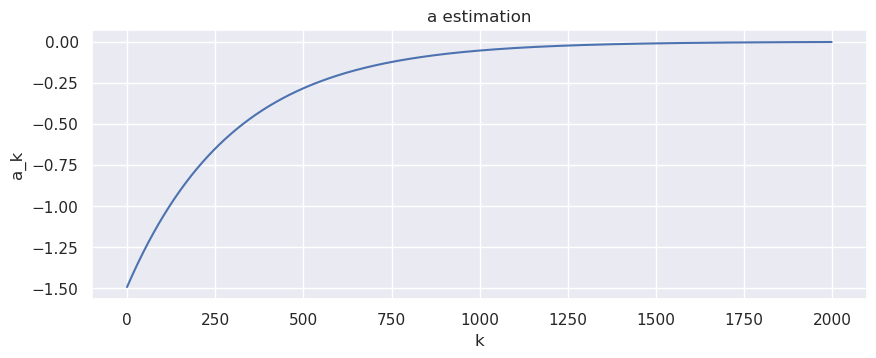

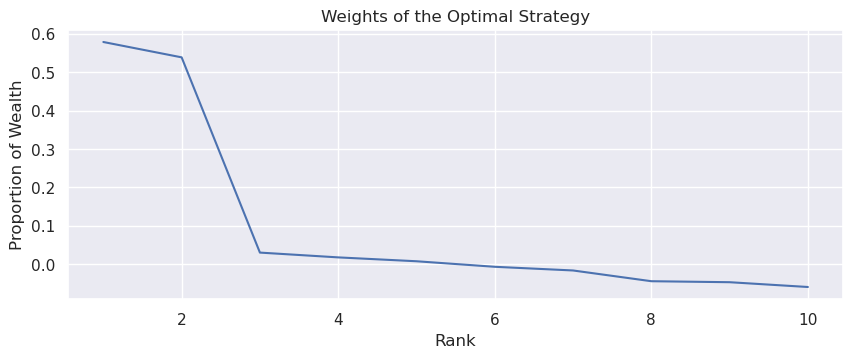

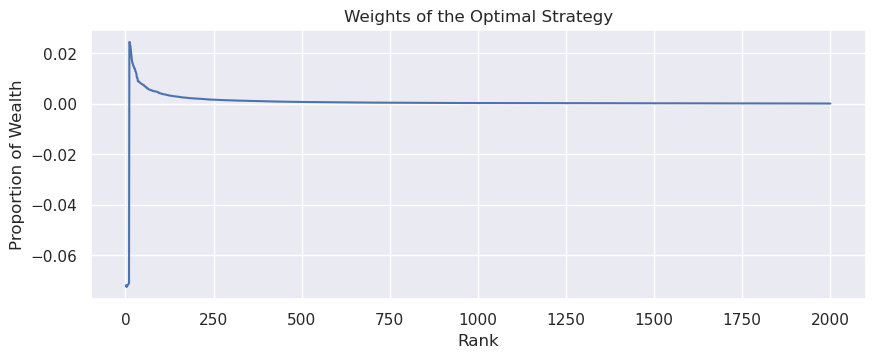

In [37]:
# Estimate a
method = 'direct_log'
smooth_method = 'exponential_decay_2'
smooth_parameter = 2
smooth_a = False

a = estimate_a(df_a_estimation.weights_by_rank, smooth_method=smooth_method, smooth_parameter=smooth_parameter,  smooth_a=smooth_a)
print(a[:5])

# Compute Strategy
setting = 'mixed'
N = 10
plot_date = '2013-03-28'
leverage_scaler = 0.1
a_modified = a.copy() 
# a_mofied[N-1] = sum(a[N-1:])
a_modified[d-1] = a_modified[d-2]
strategy_open = compute_weights_optimal_open(setting='pure', N=N, a=a, weights_by_rank=df_backtest.weights_by_rank, leverage_scaler=leverage_scaler)
# a = a_modified

strategy_mixed = compute_weights_optimal_open(setting=setting, N=N, a=a, weights_by_rank=df_backtest.weights_by_rank, leverage_scaler=leverage_scaler)

print(a[-3:])
# print('bar a_1 =', sum(a))
# print('bar a_1^N =', sum(a[:N]))
plot_a(a[:-1])
plot_strategy(strategy_open, plot_date)
plot_strategy(strategy_mixed, plot_date)

#### Compute Optimal Strategy and Backtest

In [30]:
risk_free_rate = 0
backtest = Backtest(strategy=strategy_mixed, weights_permno_by_rank=df_backtest.weights_permno_by_rank, 
                    returns_by_permno=df_backtest.returns_by_permno, risk_free_rate=risk_free_rate)

The average return each month was 1.053 %.
The sd was 0.0556 .
The Sharpe Ratio was 0.18884892086330937 .
The final cumulative interest in the period was 292.3796


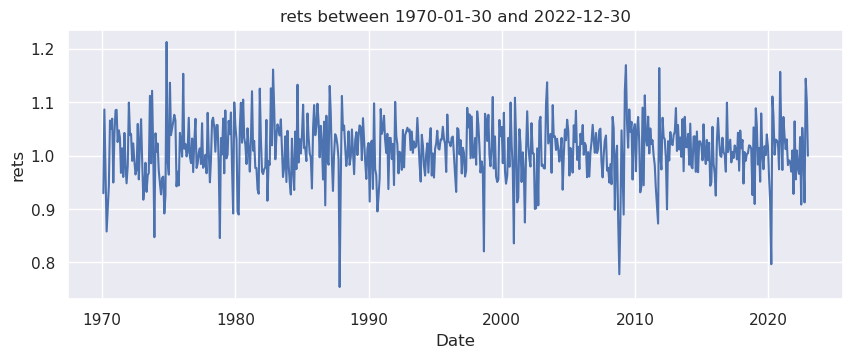

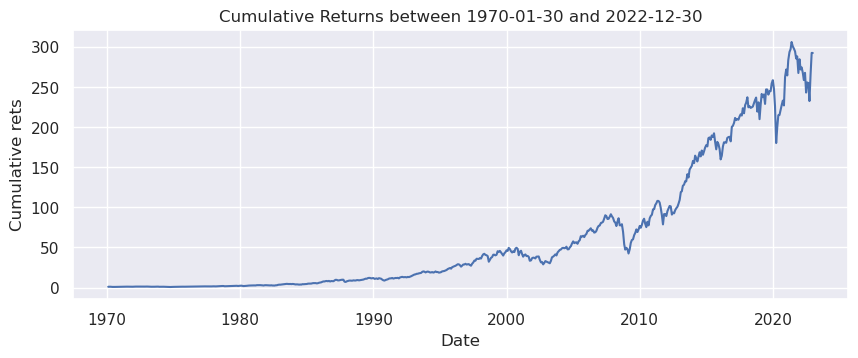

In [31]:
backtest.set_strategy(strategy_mixed)
backtest.run()

if backtest.flag_negative_return:
    print('There was at least one negative return during the backtesting so the cumulative returns contain no information.')
print('The average return each month was', backtest.average_return_percentage, '%.')
print('The sd was', backtest.sd_return, '.')
print('The Sharpe Ratio was', backtest.sharpe_ratio, '.')
print('The final cumulative interest in the period was', backtest.end_period_cumulative_wealth)
backtest.plot_rets()
backtest.plot_cumulative_rets()

### Backtest log wealth

To backtest the log wealth I used the following formula:
$$
\log V = \pi^{\top} \frac {dX_t}{X_t} - \frac 1 2 \pi^{\top} d[X,X]\pi
$$

Which numerically translates to
$$
\log V_T = \sum_{t=0}^T \left [ \pi^{\top}(t-1) \frac {X_t - X_{t-1}}{X_{t-1}} - \sum_{i,j}\frac 1 2 \pi_i(t-1) d[X_i,X_j]\pi_j(t-1) \right] \\ 
d[X_i, X_j](t) = (X_i(t)-X_i(t-1)) (X_j(t)-X_j(t-1))
$$

In [32]:
backtest.set_strategy(strategy_mixed)

In [33]:
backtest.backtest_log_wealth()

[0.0, 0.0024298289797076273, 0.03291026982047183, 0.0042848937496092684, -0.037649861777558274]
[0.0, 0.0024298289797076273, 0.030480440840764202, -0.02862537607086256, -0.04193475552716754]
The average return each month was 0.9997


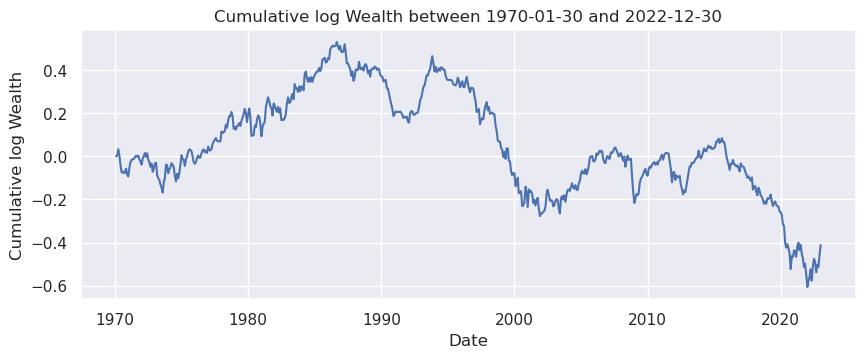

In [34]:
print(backtest.cumulative_log_wealths[0:5])
print(backtest.log_wealths[0:5])

wealth_ratios = np.exp(backtest.log_wealths)
average_wealth_ratio = np.mean(wealth_ratios)

print('The average return each month was',round(average_wealth_ratio, 4))

# backtest.plot_log_wealth()
backtest.plot_cumulative_log_wealth()

### Reverse Engineer the Values of $a$ given $\theta$ and $Y$

In [35]:
import numpy as np
from scipy.optimize import fsolve

def equations(a, theta, Y, N, d):
    a_bar_1 = np.sum(a)
    a_bar_N1 = np.sum(a[N:])
    
    eq1 = [2*theta[k] - a[k]/Y[k] - (2-a_bar_1) for k in range(N)]
    eq2 = [2*theta[k] - a_bar_N1/Y[k] - (2-a_bar_1) for k in range(N, d)]
    
    return np.array(eq1 + eq2)

def solve_a(theta, Y, N, d):
    a_init = np.ones(d)  # Initial guess
    a = fsolve(equations, a_init, args=(theta, Y, N, d))
    
    return a

In [36]:
# Extract the first rows of the weights_by_rank and strategy dataframes
Y = df_backtest.weights_by_rank.iloc[0].tolist()
theta = strategy.iloc[0].tolist()

# Solve the equations
a_values = solve_a(Y, theta, N, d)

# Print the solution
print(a_values)


NameError: name 'strategy' is not defined

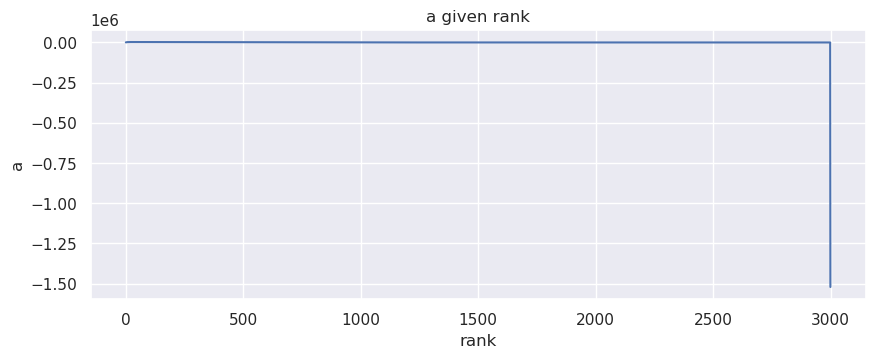

In [ ]:
plot_a(a_values)